In [20]:
import numpy as np
import numpy.linalg as lia
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn import svm 
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB

In [214]:
#run_search will perform the gridsearch in order to run the tests to plot graphs
#if run_search = False, there will be no plots
#ONLY TURN RUN_SEARCH TO TRUE IF YOU HAVE 5 HOURS TO SPARE
run_search = False

In [2]:
digits = datasets.load_digits()
wine = fetch_openml(name='wine', version=1)

In [3]:
# normalization of digits and wine data

digits_data_norm = []

for col in digits.data:
    col_norm = col/np.max(col)
    digits_data_norm.append(col_norm)

digits.data = np.asarray(digits_data_norm)

wine_data_norm = []

for col in wine.data.T:
    col_norm = col/np.amax(col)
    wine_data_norm.append(col_norm)
    
wine.data = np.asarray(wine_data_norm).T

In [4]:
# 5-fold cross validation for digits dataset

digitsTrainingSetSize = int(np.ceil(0.8 * len(digits.data)))
digitsValidationSetSize = int(len(digits.data) - digitsTrainingSetSize)

xDigitsTrainingSets = []
yDigitsTrainingSets = []
xDigitsValidationSets = []
yDigitsValidationSets = []

for foldIndex in range(5):

    xValidationSet = []
    yValidationSet = []

    for index, data in enumerate(digits.data[foldIndex*digitsValidationSetSize:((foldIndex*digitsValidationSetSize)+digitsValidationSetSize)]):
        xValidationSet.append(data.tolist())
        yValidationSet.append(digits.target[index+(foldIndex*digitsValidationSetSize)])
    
    xTrainingSet = []
    yTrainingSet = []

    for index, data in enumerate(digits.data.tolist()):
        if data not in xValidationSet:
            xTrainingSet.append(data)
            yTrainingSet.append(digits.target[index])
            
    xDigitsTrainingSets.append(xTrainingSet)
    yDigitsTrainingSets.append(yTrainingSet)
    xDigitsValidationSets.append(xValidationSet)
    yDigitsValidationSets.append(yValidationSet)
    
# 5-fold cross validation for wine dataset

wineTrainingSetSize = int(np.ceil(0.8 * len(wine.data)))
wineValidationSetSize = int(len(wine.data) - wineTrainingSetSize)

xWineTrainingSets = []
yWineTrainingSets = []
xWineValidationSets = []
yWineValidationSets = []

for foldIndex in range(5):

    xValidationSet = []
    yValidationSet = []
    for index, data in enumerate(wine.data[foldIndex*wineValidationSetSize:((foldIndex*wineValidationSetSize)+wineValidationSetSize)]):
        xValidationSet.append(data.tolist())
        yValidationSet.append(wine.target[index+(foldIndex*wineValidationSetSize)])
    
    xTrainingSet = []
    yTrainingSet = []
    
    for index, data in enumerate(wine.data.tolist()):
        if data not in xValidationSet:
            xTrainingSet.append(data)
            yTrainingSet.append(wine.target[index])
            
    xWineTrainingSets.append(xTrainingSet)
    yWineTrainingSets.append(yTrainingSet)
    xWineValidationSets.append(xValidationSet)
    yWineValidationSets.append(yValidationSet)

In [5]:
# one-hot encoding of y for digits dataset

numberOfDigitsTargets = 10
numberOfWineTargets = 3

for index, fold in enumerate(yDigitsTrainingSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfDigitsTargets)
        encoding[y] = 1
        encodedFold.append(encoding.tolist())
    yDigitsTrainingSets[index] = encodedFold
    
for index, fold in enumerate(yDigitsValidationSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfDigitsTargets)
        encoding[y] = 1
        encodedFold.append(encoding.tolist())
    yDigitsValidationSets[index] = encodedFold

# one-hot encoding of y for wine dataset

for index, fold in enumerate(yWineTrainingSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfWineTargets)
        encoding[int(y)-1] = 1
        encodedFold.append(encoding.tolist())
    yWineTrainingSets[index] = encodedFold
    
for index, fold in enumerate(yWineValidationSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfWineTargets)
        encoding[int(y)-1] = 1
        encodedFold.append(encoding.tolist())
    yWineValidationSets[index] = encodedFold


In [6]:
def getRandomIndices(arr, batch_size):
    indices = []
    
    if batch_size > len(arr):
        print("Error: batch size larger than size of dataset.")
        return
    
    while batch_size > 0:
        x = np.floor(np.random.random() * len(arr))
        if x not in indices:
            indices.append(int(x))
            batch_size -= 1
    
    return indices

In [7]:
# gradient descent class
 
class GradientDescent:
    
    def __init__(self, batch_size, learning_rate=0.5, momentum=0.9, max_termination_condition=25, max_iters=1000):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.max_termination_condition = max_termination_condition
        self.max_iters = max_iters
        self.deltas = []
        
    def run(self, gradient_fn, x, y, w):
        t = 1
        
        max_accuracy = -1
        termination_count = 0        
        weight_history = []
        error_history = []
                
        for number_of_targets in range(len(y[0])):
            weight_history.append([])
        
        while termination_count < self.max_termination_condition and t < self.max_iters:
            gradients = gradient_fn(x, y, w, self.batch_size)   
            
            for c in range(len(y[0])):
                if(t==1):
                    w[c] = w[c] - self.learning_rate * gradients[c]
                else:
                    delta_w = (self.momentum)*(self.deltas[-(len(y[0]))]) + (1-self.momentum)*gradients[c]
                    w[c] = w[c] - (self.learning_rate)*(delta_w)
                self.deltas.append(w[c])
            
            a = np.asarray(x)
            b = np.asarray(w)
    
            yh=[]
            for i, x_c in enumerate(a):
                yh_x=[]

                for c in range(len(b)):
                    w_x =  b[c] @ x_c
                    num = np.exp(w_x)

                    den = 0
                    for i in range(len(b)):
                        w_x =  b[i] @ x_c
                        den += np.exp(w_x)

                    yh_c = num/den
                    yh_x.append(yh_c)
                    
                yh.append(yh_x)
                
            step_accuracy = 0
                
            def accurate(a, b):
                return np.argmax(a) == np.argmax(b)
                
            for sample_index, yh_x in enumerate(yh):
                if accurate(yh_x, y[sample_index]):
                    step_accuracy += 1
                    
            step_accuracy /= len(x)
            
            for c in range(len(b)):
                weight_history[c].append(w[c])
            
            error_history.append(step_accuracy)
            
            # We use an alternate termination condition that terminates faster as
            # the suggested condition ran for a longtime for us (~1hr).
            
            # We track the best training accuracy encountered, and if the 
            # next max_termination_condition-number of steps do not have a better accuracy, then
            # it terminates.

            if step_accuracy > max_accuracy:
                max_accuracy = step_accuracy
                termination_count = 0
                print(f"\t\tStep {t}: new best accuracy of {max_accuracy:.3f}")
            else:
                termination_count += 1
                print(f"\t\tStep {t}")
            
            t += 1
        
        # take the weight prior to the last max_termination_condition-number of weights
        # (as it is guaranteed to be the best prior to termination).
        
        index_best = len(error_history)-self.max_termination_condition-1
        
        w_best = []
        
        for c in range(len(y[0])):
            w_best.append(weight_history[c][index_best])
        
        return w_best

In [8]:
# logistic regression

class LogisticRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
            
    def fit(self, x, y, optimizer):
        def gradient(x, y, w, batch_size):
            gradients = np.zeros(len(w)).tolist()

            indices = getRandomIndices(x, batch_size)

            for index in indices:
                a = np.asarray(x[index])
                b = np.asarray(y[index])

                for c in range(len(b)):
                    w_x =  w[c] @ a
                    num = np.exp(w_x)

                    den = 0
                    for i in range(len(b)):
                        w_x =  w[i] @ a
                        den += np.exp(w_x)

                    yh_c = num/den

                    y_c = b[c]
                    
                    cost_c = np.dot(yh_c - y_c, a)
                    
                    gradients[c] += cost_c

            return gradients
        
        if self.add_bias:
            x = np.asarray(x)
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        w0 = []
        for c in range(len(y[0])):
            w0.append(np.zeros(len(x[0])))
            
        self.w = optimizer.run(gradient, x, y, w0)
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.asarray(x)
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        a = np.asarray(x)
        b = np.asarray(self.w)

        yh=[]
        
        for i, x_c in enumerate(a):
            yh_x=[]
            
            for c in range(len(b)):
                w_x =  b[c] @ x_c
                num = np.exp(w_x)

                den = 0
                for i in range(len(b)):
                    w_x =  b[i] @ x_c
                    den += np.exp(w_x)

                yh_c = num/den
                yh_x.append(yh_c)
                
            yh.append(yh_x)
        
        return yh

In [9]:
def runLogisticRegression(batch_size, learning_rate, momentum):
    def accurate(a, b):
        return np.argmax(a) == np.argmax(b)

    def cost(yh, y):
        return y * np.log1p(np.exp(-yh)) + (1-yh) * np.log1p(np.exp(yh))

    print("Model hyper-parameters:")
    print("\tMini-batch size:", batch_size)
    print("\tLearning rate:", learning_rate)
    print("\tMomentum:", momentum)
    print("\n")

    digits_training_accuracy = 0
    digits_training_cost = 0
    digits_validation_accuracy = 0
    digits_validation_cost = 0

    print("Digits gradient descent:")

    for fold_index, fold in enumerate(xDigitsTrainingSets):
        print(f"\tCross-validation fold {fold_index+1}")

        gradientDescentModel = GradientDescent(batch_size, learning_rate, momentum)
        logisticRegressionModel = LogisticRegression(add_bias=True)

        logisticRegressionModel.fit(fold, yDigitsTrainingSets[fold_index], gradientDescentModel)
        yh_training = logisticRegressionModel.predict(xDigitsTrainingSets[fold_index])
        yh_validation = logisticRegressionModel.predict(xDigitsValidationSets[fold_index])

        for sample_index, yh_x in enumerate(yh_training):
            if accurate(yh_x, yDigitsTrainingSets[fold_index][sample_index]):
                digits_training_accuracy += 1
            c = np.argmax(yDigitsTrainingSets[fold_index][sample_index])
            cst = cost(yh_x[c], yDigitsTrainingSets[fold_index][sample_index][c])
            digits_training_cost += cst

        for sample_index, yh_x in enumerate(yh_validation):
            if accurate(yh_x, yDigitsValidationSets[fold_index][sample_index]):
                digits_validation_accuracy += 1
            c = np.argmax(yDigitsValidationSets[fold_index][sample_index])
            cst = cost(yh_x[c], yDigitsValidationSets[fold_index][sample_index][c])
            digits_validation_cost += cst

    digits_training_accuracy /= 4*len(digits.data)
    digits_training_cost /= 4
    digits_validation_accuracy /= len(digits.data)

    wine_training_accuracy = 0
    wine_training_cost = 0
    wine_validation_accuracy = 0
    wine_validation_cost = 0

    print("Wine gradient descent:")

    for fold_index, fold in enumerate(xWineTrainingSets):
        print(f"\tCross-validation fold {fold_index+1}")

        gradientDescentModel = GradientDescent(batch_size, learning_rate, momentum)
        logisticRegressionModel = LogisticRegression(add_bias=True)

        logisticRegressionModel.fit(fold, yWineTrainingSets[fold_index], gradientDescentModel)
        yh_training = logisticRegressionModel.predict(xWineTrainingSets[fold_index])
        yh_validation = logisticRegressionModel.predict(xWineValidationSets[fold_index])

        for sample_index, yh_x in enumerate(yh_training):
            if accurate(yh_x, yWineTrainingSets[fold_index][sample_index]):
                wine_training_accuracy += 1
            c = np.argmax(yWineTrainingSets[fold_index][sample_index])
            cst = cost(yh_x[c], yWineTrainingSets[fold_index][sample_index][c])
            wine_training_cost += cst

        for sample_index, yh_x in enumerate(yh_validation):
            if accurate(yh_x, yWineValidationSets[fold_index][sample_index]):
                wine_validation_accuracy += 1
            c = np.argmax(yWineValidationSets[fold_index][sample_index])
            cst = cost(yh_x[c], yWineValidationSets[fold_index][sample_index][c])
            wine_validation_cost += cst

    wine_training_accuracy /= 4*len(wine.data)
    wine_training_cost /= 4
    wine_validation_accuracy /= len(wine.data)

    print("\n")
    print(f"Digits training accuracy: {digits_training_accuracy*100:.1f}%")
    print(f"Digits training cost: {digits_training_cost:.3f}")
    print(f"Digits validation accuracy: {digits_validation_accuracy*100:.1f}%")
    print(f"Digits validation cost: {digits_validation_cost:.3f}")
    print(f"Wine training accuracy: {wine_training_accuracy*100:.1f}%")
    print(f"Wine training cost: {wine_training_cost:.3f}")
    print(f"Wine validation accuracy: {wine_validation_accuracy*100:.1f}%")
    print(f"Wine validation cost: {wine_validation_cost:.3f}")
    
    return (digits_validation_accuracy, digits_validation_cost, wine_validation_accuracy, wine_validation_cost)



In [226]:

default_run = runLogisticRegression(30, 0.04, 0.2)

Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.04
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.185
		Step 2: new best accuracy of 0.263
		Step 3: new best accuracy of 0.392
		Step 4
		Step 5: new best accuracy of 0.647
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10: new best accuracy of 0.692
		Step 11
		Step 12: new best accuracy of 0.732
		Step 13: new best accuracy of 0.803
		Step 14: new best accuracy of 0.815
		Step 15
		Step 16
		Step 17
		Step 18: new best accuracy of 0.901
		Step 19
		Step 20
		Step 21: new best accuracy of 0.905
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best accuracy of 0.932
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48: new best accuracy of 0.941
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54


		Step 22
		Step 23: new best accuracy of 0.951
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
	Cross-validation fold 2
		Step 1: new best accuracy of 0.476
		Step 2
		Step 3: new best accuracy of 0.734
		Step 4
		Step 5
		Step 6: new best accuracy of 0.748
		Step 7
		Step 8: new best accuracy of 0.937
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28: new best accuracy of 0.944
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
	Cross-validatio

In [10]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.C = len(y[0])
        return self
    
    def predict(self, x_test):
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test),dtype=int)
        counts = np.zeros((num_test, self.C))
        
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            k_count=np.zeros(self.K, dtype=int)
            
            for s, arr in enumerate(self.y[knns[i,:]]):
                k_count[s] = np.argmax(arr)
            
            y_prob_i, counts_i = np.unique(k_count, return_counts=True)
            y_prob[i] = int(y_prob_i[np.argmax(counts_i)])
        
        return y_prob, knns

In [11]:
KNNmodel = KNN(K=11)

digits_knn_accuracy = 0

for fold in range(5):
    y_prob, knns = KNNmodel.fit(np.asarray(xDigitsTrainingSets[fold]), np.asarray(yDigitsTrainingSets[fold])).predict(np.asarray(xDigitsValidationSets[fold]))
    
    for i, prob in enumerate(y_prob):
        if prob == np.argmax(yDigitsValidationSets[fold][i]):
            digits_knn_accuracy += 1

digits_knn_accuracy /= len(digits.data)

print(f"KNN digits validation accuracy: {digits_knn_accuracy*100:.1f}%")

KNNmodel = KNN(K=7)

wine_knn_accuracy = 0

for fold in range(5):
    y_prob, knns = KNNmodel.fit(np.asarray(xWineTrainingSets[fold]), np.asarray(yWineTrainingSets[fold])).predict(np.asarray(xWineValidationSets[fold]))
    
    for i, prob in enumerate(y_prob):
        if prob == np.argmax(yWineValidationSets[fold][i]):
            wine_knn_accuracy += 1
            
wine_knn_accuracy /= len(wine.data)

print(f"KNN wine validation accuracy: {wine_knn_accuracy*100:.1f}%")

KNN digits validation accuracy: 95.7%
KNN wine validation accuracy: 85.4%


In [12]:
digits_naive_accuracy = 0

for fold in range(5):
    labels_training = np.zeros(len(yDigitsTrainingSets[fold]))
    
    for i, arr in enumerate(yDigitsTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yDigitsValidationSets[fold]))
    
    for i, arr in enumerate(yDigitsValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    gnb = GaussianNB()
    y_pred = gnb.fit(np.asarray(xDigitsTrainingSets[fold]), labels_training).predict(np.asarray(xDigitsValidationSets[fold]))

    for i, label in enumerate(y_pred):
        if label == labels_validation[i]:
            digits_naive_accuracy += 1

digits_naive_accuracy /= len(digits.data)

print(f"Naive base digits validation accuracy: {digits_naive_accuracy*100:.1f}%")

wine_naive_accuracy = 0

for fold in range(5):
    labels_training = np.zeros(len(yWineTrainingSets[fold]))
    
    for i, arr in enumerate(yWineTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yWineValidationSets[fold]))
    
    for i, arr in enumerate(yWineValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    gnb = GaussianNB()
    y_pred = gnb.fit(np.asarray(xWineTrainingSets[fold]), labels_training).predict(np.asarray(xWineValidationSets[fold]))

    for i, label in enumerate(y_pred):
        if label == labels_validation[i]:
            wine_naive_accuracy += 1

wine_naive_accuracy /= len(wine.data)

print(f"Naive base wine validation accuracy: {wine_naive_accuracy*100:.1f}%")

Naive base digits validation accuracy: 81.1%
Naive base wine validation accuracy: 93.8%


In [13]:
def HoGFeatures(img, cellSize, blockSize, nbins):
    cell_size = (cellSize, cellSize)
    block_size = (blockSize, blockSize)
    
    hog = cv.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                     img.shape[0] // cell_size[0] * cell_size[0]),
                           _blockSize=(block_size[1] * cell_size[1],
                                       block_size[0] * cell_size[0]),
                           _blockStride=(cell_size[1], cell_size[0]),
                           _cellSize=(cell_size[1], cell_size[0]),
                           _nbins=nbins
    )
    
    return hog

In [14]:
def makeHoGFeatures(imageArray):
    HoG = HoGFeatures(imageArray[0], 2, 2, 2)
    features = []
    
    for i, image in enumerate(imageArray):
        features.append(HoG.compute((image*255).astype(np.uint8)))
        
    features = np.array(np.squeeze(features))
    
    return features

In [15]:
digits_svc_accuracy = 0

for fold in range(5):
    numbers_training = []
    numbers_validation = []
    
    for i, number in enumerate(xDigitsTrainingSets[fold]):
        numbers_training.append(np.asarray(number).reshape(8, 8))
        
    for i, number in enumerate(xDigitsValidationSets[fold]):
        numbers_validation.append(np.asarray(number).reshape(8, 8))  
        
    HoGs_training = makeHoGFeatures(np.asarray(numbers_training))
    HoGs_validation = makeHoGFeatures(np.asarray(numbers_validation))

    clf = svm.SVC(gamma='auto', C=100) 
    
    labels_training = np.zeros(len(yDigitsTrainingSets[fold]))
    
    for i, arr in enumerate(yDigitsTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yDigitsValidationSets[fold]))
    
    for i, arr in enumerate(yDigitsValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    clf.fit(HoGs_training, labels_training)

    labels_predicted = clf.predict(HoGs_validation)
    
    for i, label in enumerate(labels_predicted):
        if label == labels_validation[i]:
            digits_svc_accuracy += 1

digits_svc_accuracy /= len(digits.data)

print(f"SVC digits validation accuracy: {digits_svc_accuracy*100:.1f}%")

SVC digits validation accuracy: 89.6%


In [190]:
# Analysis of model hyper-parameters

batch_size = 30
learning_rate = 0.04
momentum = 0.2


[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


In [191]:
# Analysis of changing batch size
if run_search:
    batch_size_tests = np.array(range(2, 40, 2))#[30, 25, 20, 15, 10, 5]
    batch_size_results = []

    for test in batch_size_tests:
        batch_size_results.append(runLogisticRegression(test, learning_rate, momentum))

Model hyper-parameters:
	Mini-batch size: 2
	Learning rate: 0.04
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.192
		Step 2: new best accuracy of 0.316
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.375
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31: new best accuracy of 0.436
		Step 32: new best accuracy of 0.509
		Step 33
		Step 34: new best accuracy of 0.636
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41: new best accuracy of 0.690
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62: new best accuracy of 0.743
		Step 63
		Step 64
		Step 65
		S

		Step 1: new best accuracy of 0.100
		Step 2
		Step 3: new best accuracy of 0.105
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.114
		Step 9: new best accuracy of 0.121
		Step 10: new best accuracy of 0.186
		Step 11: new best accuracy of 0.251
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18: new best accuracy of 0.325
		Step 19: new best accuracy of 0.496
		Step 20: new best accuracy of 0.532
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30: new best accuracy of 0.572
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37: new best accuracy of 0.652
		Step 38
		Step 39: new best accuracy of 0.751
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
	Cross-validation fold 2
		Step 1

		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55: new best accuracy of 0.944
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
	Cross-validation fold 5
		Step 1: new best accuracy of 0.413
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6: new best accuracy of 0.797
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22: new best accuracy of 0.811
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31: new best accuracy of 0.818
		Step 32
		Step 33: new best accuracy of 0.846
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step

		Step 9
		Step 10: new best accuracy of 0.470
		Step 11
		Step 12: new best accuracy of 0.568
		Step 13: new best accuracy of 0.579
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20: new best accuracy of 0.607
		Step 21: new best accuracy of 0.821
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13: new best accuracy of 0.720
		Step 14
		Step 15: new best accuracy of 0.804
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34: new best accuracy

		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48: new best accuracy of 0.897
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
	Cross-validation fold 3
		Step 1: new best accuracy of 0.150
		Step 2: new best accuracy of 0.171
		Step 3: new best accuracy of 0.245
		Step 4
		Step 5
		Step 6
		Step 7: new best accuracy of 0.495
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.599
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20: new best accuracy of 0.616
		Step 21
		Step 22: new best accuracy of 0.744
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40: new best accuracy of 0.821
		Step 41
		

		Step 21
		Step 22: new best accuracy of 0.839
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best accuracy of 0.853
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52


Digits training accuracy: 91.4%
Digits training cost: 1867.620
Digits validation accuracy: 87.1%
Digits validation cost: 1897.265
Wine training accuracy: 89.6%
Wine training cost: 179.705
Wine validation accuracy: 46.1%
Wine validation cost: 200.138
Model hyper-parameters:
	Mini-batch size: 10
	Learning rate: 0.04
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.272
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.493
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.604
		Step 15
		Step 16: new

		Step 80: new best accuracy of 0.927
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93: new best accuracy of 0.935
		Step 94
		Step 95
		Step 96
		Step 97: new best accuracy of 0.939
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.336
		Step 2: new best accuracy of 0.497
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.531
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.797
		Step 15
		Step 16: new best accuracy of 0.804
		Step 17: new best accuracy of 0.811
		Step 18
		Step 19: new best accuracy of 0.818
		Step 20
		Step 21
		Step 22
		Step 2

		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61: new best accuracy of 0.900
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66: new best accuracy of 0.916
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85: new best accuracy of 0.919
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93: new best accuracy of 0.926
		Step 94: new best accuracy of 0.928
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105: new best accuracy of 0.933
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117: new best accuracy of 0.936
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 1

		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29: new best accuracy of 0.923
		Step 30
		Step 31
		Step 32: new best accuracy of 0.944
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44: new best accuracy of 0.951
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
	Cross-validation fold 4
		Step 1: new best accuracy of 0.266
		Step 2: new best accuracy of 0.559
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7: new best accuracy of 0.678
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12: new best accuracy of 0.825
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26: new best accuracy of 0.853
		Step 27
		Step 28


		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62: new best accuracy of 0.907
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77: new best accuracy of 0.909
		Step 78: new best accuracy of 0.913
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89: new best accuracy of 0.914
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95: new best accuracy of 0.916
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106: new best accuracy of 0.919
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114: new best accuracy of 0.920
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121: new best accuracy of 

		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
	Cross-validation fold 2
		Step 1: new best accuracy of 0.275
		Step 2
		Step 3
		Step 4: new best accuracy of 0.502
		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.618
		Step 9
		Step 10
		Step 11: new best accuracy of 0.862
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25: new best accuracy of 0.885
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36: new best accuracy of 0.900
		Step 37: new best accuracy of 0.904
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49: new best accuracy of 0.906
		Step 50
		Step 51
		Step 52
		Step 5

		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30: new best accuracy of 0.937
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50: new best accuracy of 0.944
		Step 51
		Step 52: new best accuracy of 0.958
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
	Cross-validation fold 5
		Step 1: new best accuracy of 0.608
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6: new best accuracy of 0.706
		Step 7
		Step 8: new best accuracy of 0.839
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step

		Step 18
		Step 19
		Step 20: new best accuracy of 0.866
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25: new best accuracy of 0.873
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41: new best accuracy of 0.887
		Step 42: new best accuracy of 0.895
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54: new best accuracy of 0.898
		Step 55
		Step 56
		Step 57: new best accuracy of 0.903
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62: new best accuracy of 0.904
		Step 63
		Step 64
		Step 65
		Step 66: new best accuracy of 0.913
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79: new best accuracy of 0.921
		Step 80
		Step 81: new best accuracy of 0.924
		Step 82
		Step 83
		Step 84
		Step 85: new best accuracy of 0.926
		Step 86
		

		Step 40
		Step 41
		Step 42
		Step 43: new best accuracy of 0.914
		Step 44: new best accuracy of 0.923
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58: new best accuracy of 0.931
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80: new best accuracy of 0.935
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88: new best accuracy of 0.938
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94: new best accuracy of 0.940
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
	Cross-valid

		Step 112
		Step 113
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4: new best accuracy of 0.531
		Step 5: new best accuracy of 0.818
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best accuracy of 0.825
		Step 28
		Step 29: new best accuracy of 0.839
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38: new best accuracy of 0.923
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52: new best accuracy of 0.958
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		S

		Step 64: new best accuracy of 0.929
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76: new best accuracy of 0.930
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92: new best accuracy of 0.931
		Step 93
		Step 94
		Step 95
		Step 96: new best accuracy of 0.933
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102: new best accuracy of 0.938
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127: new best accuracy of 0.943
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135: new best accuracy of 0.944
		Step 136
		Step 137
		Step 138
		Step 139
		St

		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
	Cross-validation fold 2
		Step 1: new best accuracy of 0.713
		Step 2
		Step 3
		Step 4
		Step 5: new best accuracy of 0.727
		Step 6: new best accuracy of 0.741
		Step 7: new best accuracy of 0.902
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12: new best accuracy of 0.909
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18: new best accuracy of 0.930
		Step 19
		Step 20: new best accuracy of 0.937
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best accuracy of 0.944
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47: new best accuracy of 0.951
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		

		Step 21
		Step 22
		Step 23
		Step 24
		Step 25: new best accuracy of 0.885
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36: new best accuracy of 0.889
		Step 37
		Step 38
		Step 39: new best accuracy of 0.898
		Step 40: new best accuracy of 0.905
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45: new best accuracy of 0.908
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51: new best accuracy of 0.912
		Step 52
		Step 53
		Step 54
		Step 55: new best accuracy of 0.916
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70: new best accuracy of 0.925
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76: new best accuracy of 0.933
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88: new best accuracy of 0.933
		Step 89
		Step 90
		Step 91
		Step 92


		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.811
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best accuracy of 0.902
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30: new best accuracy of 0.930
		Step 31
		Step 32
		Step 33: new best accuracy of 0.951
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57: new best accuracy of 0.958
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72: new best accuracy of 0.972
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step

		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82: new best accuracy of 0.938
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97: new best accuracy of 0.941
		Step 98
		Step 99
		Step 100: new best accuracy of 0.942
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120: new best accuracy of 0.944
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134: new best accuracy of 0.946
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150

		Step 36
		Step 37
		Step 38


Digits training accuracy: 94.7%
Digits training cost: 1341.213
Digits validation accuracy: 90.7%
Digits validation cost: 1405.581
Wine training accuracy: 94.2%
Wine training cost: 155.895
Wine validation accuracy: 68.5%
Wine validation cost: 174.440
Model hyper-parameters:
	Mini-batch size: 28
	Learning rate: 0.04
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.280
		Step 2
		Step 3
		Step 4: new best accuracy of 0.536
		Step 5: new best accuracy of 0.547
		Step 6: new best accuracy of 0.617
		Step 7: new best accuracy of 0.629
		Step 8: new best accuracy of 0.640
		Step 9
		Step 10: new best accuracy of 0.674
		Step 11
		Step 12: new best accuracy of 0.733
		Step 13: new best accuracy of 0.849
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19: new best accuracy of 0.896
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24: new best accuracy of 0.905
		Step 25: new best accuracy of 0.907
		Step 2

		Step 66
		Step 67
		Step 68: new best accuracy of 0.942
		Step 69: new best accuracy of 0.949
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82: new best accuracy of 0.951
		Step 83: new best accuracy of 0.953
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107: new best accuracy of 0.954
		Step 108: new best accuracy of 0.957
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4: new b

		Step 8
		Step 9
		Step 10: new best accuracy of 0.777
		Step 11
		Step 12: new best accuracy of 0.844
		Step 13
		Step 14
		Step 15
		Step 16: new best accuracy of 0.880
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23: new best accuracy of 0.895
		Step 24: new best accuracy of 0.903
		Step 25
		Step 26
		Step 27: new best accuracy of 0.911
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39: new best accuracy of 0.919
		Step 40
		Step 41: new best accuracy of 0.920
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60: new best accuracy of 0.925
		Step 61
		Step 62: new best accuracy of 0.933
		Step 63: new best accuracy of 0.941
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75: new best accu

		Step 15
		Step 16
		Step 17: new best accuracy of 0.860
		Step 18: new best accuracy of 0.909
		Step 19: new best accuracy of 0.916
		Step 20: new best accuracy of 0.937
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best accuracy of 0.951
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
	Cross-validation fold 3
		Step 1: new best accuracy of 0.413
		Step 2
		Step 3
		Step 4: new best accuracy of 0.881
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13: new best accuracy of 0.895
		Step 14
		Step 15
		Step 16: new best accuracy of 0.902
		Step 17
		Step 18
		Step 19
		Step 20: new best accuracy of 0.944
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		St

		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79: new best accuracy of 0.947
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
	Cross-validation fold 4
		Step 1: new best accuracy of 0.361
		Step 2
		Step 3: new best accuracy of 0.539
		Step 4
		Step 5
		Step 6
		Step 7: new best accuracy of 0.711
		Step 8
		Step 9
		Step 10: new best accuracy of 0.759
		Step 11
		Step 12
		Step 13: new best accuracy of 0.830
		Step 14
		Step 15
		Step 16: new best accuracy of 0.878
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29: new best accuracy of 0.881
		Step 30: new best accuracy of 0.892
		Step 31: new best accuracy of 0.903
		Step 32
		Step 33
		Step 34
		Step 35: new best

		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54: new best accuracy of 0.940
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67: new best accuracy of 0.941
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72: new best accuracy of 0.946
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
	Cross-validation fold 2
		Step 1: new best accuracy of 0.103
		Step 2: new best accuracy of 0.195
		Step 3: new best accuracy of 0.230
		Step 4: new best accuracy of 0.390
		Step 5: new best accuracy of 0.608
		Step 6: new best accuracy of 0.616
		Step 7: new best accuracy of 0.717
		Step 8: new best accuracy of 0.731
		Step 9: new b

		Step 11: new best accuracy of 0.783
		Step 12
		Step 13
		Step 14: new best accuracy of 0.787
		Step 15: new best accuracy of 0.793
		Step 16
		Step 17: new best accuracy of 0.831
		Step 18: new best accuracy of 0.877
		Step 19
		Step 20: new best accuracy of 0.906
		Step 21
		Step 22
		Step 23: new best accuracy of 0.926
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33: new best accuracy of 0.935
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43: new best accuracy of 0.939
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59: new best accuracy of 0.943
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66: new best accuracy of 0.946
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72: new best accuracy of 0.947
		Step 73
		Step 74: new best accuracy of 0.

		Step 8: new best accuracy of 0.715
		Step 9
		Step 10
		Step 11
		Step 12: new best accuracy of 0.746
		Step 13: new best accuracy of 0.792
		Step 14: new best accuracy of 0.865
		Step 15
		Step 16: new best accuracy of 0.907
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28: new best accuracy of 0.912
		Step 29: new best accuracy of 0.919
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39: new best accuracy of 0.921
		Step 40
		Step 41
		Step 42
		Step 43: new best accuracy of 0.928
		Step 44: new best accuracy of 0.934
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56: new best accuracy of 0.938
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75: new best accu

		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
	Cross-validation fold 2
		Step 1: new best accuracy of 0.420
		Step 2
		Step 3
		Step 4: new best accuracy of 0.741
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11: new best accuracy of 0.825
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18: new best accuracy of 0.881
		Step 19
		Step 20: new best accuracy of 0.937
		Step 21
		Step 22: new best accuracy of 0.944
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
	Cross-validation fold 3
		Step 1: new best accuracy of 0.413
		Step 2: new best accuracy of 0.503
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.531
		Step 9: new b

		Step 11: new best accuracy of 0.825
		Step 12
		Step 13
		Step 14: new best accuracy of 0.853
		Step 15
		Step 16: new best accuracy of 0.858
		Step 17: new best accuracy of 0.880
		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.893
		Step 22
		Step 23: new best accuracy of 0.894
		Step 24: new best accuracy of 0.902
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30: new best accuracy of 0.914
		Step 31
		Step 32: new best accuracy of 0.919
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38: new best accuracy of 0.926
		Step 39
		Step 40: new best accuracy of 0.931
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47: new best accuracy of 0.933
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55: new best accuracy of 0.937
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61: new best accuracy of 0.942
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 7

		Step 8: new best accuracy of 0.902
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.951
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
	Cross-validation fold 5
		Step 1: new best accuracy of 0.413
		Step 2: new best accuracy of 0.497
		Step 3: new best accuracy of 0.587
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.853
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34


Digits training accuracy: 95.0%
Digits training cost: 1231.475
Digits validation accur

In [192]:
# Analysis of changing learning rate
if run_search:
    learning_rate_tests = np.array(range(1, 20, 1))/100#[0.02, 0.04, 0.06, 0.08]
    learning_rate_results = []

    for test in learning_rate_tests:
        learning_rate_results.append(runLogisticRegression(batch_size, test, momentum))

Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.01
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.290
		Step 2: new best accuracy of 0.326
		Step 3
		Step 4
		Step 5: new best accuracy of 0.397
		Step 6: new best accuracy of 0.403
		Step 7: new best accuracy of 0.499
		Step 8
		Step 9: new best accuracy of 0.540
		Step 10
		Step 11
		Step 12: new best accuracy of 0.761
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.838
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29: new best accuracy of 0.863
		Step 30
		Step 31
		Step 32: new best accuracy of 0.866
		Step 33
		Step 34
		Step 35: new best accuracy of 0.869
		Step 36
		Step 37
		Step 38: new best accuracy of 0.894
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52: new best accuracy o

		Step 15: new best accuracy of 0.770
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22: new best accuracy of 0.837
		Step 23
		Step 24: new best accuracy of 0.857
		Step 25: new best accuracy of 0.882
		Step 26: new best accuracy of 0.896
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34: new best accuracy of 0.914
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44: new best accuracy of 0.916
		Step 45
		Step 46
		Step 47: new best accuracy of 0.925
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.566
		Step 9
		Step 10
	

		Step 72: new best accuracy of 0.928
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86: new best accuracy of 0.930
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95: new best accuracy of 0.931
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106: new best accuracy of 0.933
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118: new best accuracy of 0.938
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126: new best accuracy of 0.943
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142: new best accuracy of 0.944
		Step 143
		Step 144
		Step 145
		Step 146
		Step 

		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best accuracy of 0.944
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
	Cross-validation fold 3
		Step 1: new best accuracy of 0.413
		Step 2: new best accuracy of 0.476
		Step 3: new best accuracy of 0.741
		Step 4
		Step 5
		Step 6
		Step 7: new best accuracy of 0.748
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12: new best accuracy of 0.783
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.888
		Step 22
		Step 23: new best accuracy of 0.909
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31: new best accuracy of 0.930
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		

		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
	Cross-validation fold 4
		Step 1: new best accuracy of 0.182
		Step 2: new best accuracy of 0.271
		Step 3
		Step 4: new best accuracy of 0.451
		Step 5
		Step 6: new best accuracy of 0.586
		Step 7
		Step 8: new best accuracy of 0.592
		Step 9: new best accuracy of 0.710
		Step 10
		Step 11
		Step 12: new best accuracy of 0.747
		Step 13
		Step 14: new best accuracy of 0.827
		Step 15
		Step 16: new best accuracy of 0.849
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22: new best accuracy of 0.884
		Step 23: new best accuracy of 0.894
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32: new best accuracy of 0.899
		Step 33
		Step 34
		Step 35: new best accuracy of 0.903
		Step 36
		Step 37:

		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
	Cross-validation fold 5
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4: new best accuracy of 0.776
		Step 5
		Step 6: new best accuracy of 0.783
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.846
		Step 15
		Step 16
		Step 17
		Step 18: new best accuracy of 0.853
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30: new best accuracy of 0.860
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37: new best accuracy of 0.867
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46: new best accuracy of 0.874
		Step 47
		Step 48
		Step 49
		Step 50: new best accuracy of 0.881
		Step 51
		Step 52: new best accuracy of 0.888
		Step 53
		Step 54: new best accuracy of 0.895
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step

		Step 52: new best accuracy of 0.929
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68: new best accuracy of 0.936
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74: new best accuracy of 0.939
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83: new best accuracy of 0.942
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92: new best accuracy of 0.943
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105: new best accuracy of 0.945
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114: new best accuracy of 0.948
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Ste

		Step 52
		Step 53: new best accuracy of 0.874
		Step 54: new best accuracy of 0.888
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61: new best accuracy of 0.895
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81: new best accuracy of 0.902
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88: new best accuracy of 0.909
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108: new best accuracy of 0.930
		Step 109: new best accuracy of 0.944
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Ste

		Step 6
		Step 7
		Step 8: new best accuracy of 0.693
		Step 9
		Step 10: new best accuracy of 0.750
		Step 11
		Step 12: new best accuracy of 0.773
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best accuracy of 0.833
		Step 18: new best accuracy of 0.902
		Step 19
		Step 20: new best accuracy of 0.904
		Step 21
		Step 22: new best accuracy of 0.906
		Step 23: new best accuracy of 0.927
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39: new best accuracy of 0.931
		Step 40
		Step 41
		Step 42
		Step 43: new best accuracy of 0.946
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.336
		Step 2:

		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78: new best accuracy of 0.944
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
	Cross-validation fold 3
		Step 1: new best accuracy of 0.233
		Step 2
		Step 3: new best accuracy of 0.340
		Step 4: new best accuracy of 0.350
		Step 5: new best accuracy of 0.393
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.506
		Step 10: new best accuracy of 0.697
		Step 11: new best accuracy of 0.805
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16: new best accuracy of 0.820
		Step 17
		Step 18
		Step 19: new best accuracy of 0.840
		Step 20
		Step 21


		Step 111
		Step 112
		Step 113
	Cross-validation fold 4
		Step 1: new best accuracy of 0.413
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6: new best accuracy of 0.804
		Step 7: new best accuracy of 0.825
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best accuracy of 0.832
		Step 18: new best accuracy of 0.888
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31: new best accuracy of 0.930
		Step 32
		Step 33
		Step 34: new best accuracy of 0.944
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50: new best accuracy of 0.951
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 

		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83: new best accuracy of 0.935
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97: new best accuracy of 0.941
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121: new best accuracy of 0.942
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134: new best accuracy of 0.947
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151
		Step

		Step 21: new best accuracy of 0.869
		Step 22
		Step 23
		Step 24
		Step 25: new best accuracy of 0.894
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32: new best accuracy of 0.912
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45: new best accuracy of 0.935
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
	Cross-validation fold 2
		Step 1: new best accuracy of 0.129
		Step 2: new best accuracy of 0.202
		Step 3: new best accuracy of 0.217
		Step 4: new best accuracy of 0.397
		Step 5: new best accuracy of 0.501
		Step 6
		Step 7: new best accuracy of 0.518
		Step 8
		Step 9: new best accuracy of 0.595
		Step 10
		Step 11: new best accuracy of 0.720
		Step 12
		Step 13
		Step 14: new bes

		Step 31
		Step 32
		Step 33: new best accuracy of 0.937
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48: new best accuracy of 0.958
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
	Cross-validation fold 3
		Step 1: new best accuracy of 0.413
		Step 2
		Step 3
		Step 4
		Step 5: new best accuracy of 0.594
		Step 6
		Step 7
		Step 8: new best accuracy of 0.853
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best accuracy of 0.888
		Step 28: new best accuracy of 0.930
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35: new bes

		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73: new best accuracy of 0.938
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
	Cross-validation fold 5
		Step 1: new best accuracy of 0.099
		Step 2: new best accuracy of 0.101
		Step 3: new best accuracy of 0.303
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.325
		Step 9: new best accuracy of 0.328
		Step 10: new best accuracy of 0.525
		Step 11: new best accuracy of 0.576
		Step 12
		Step 13
		Step 14
		Step 15: new best accuracy of 0.599
		Step 16: new best accuracy of 0.675
		Step 17: new best accuracy of 0.829
		Step 18: new best accuracy of 0.876
		Step 19: new best accuracy

		Step 47
		Step 48
		Step 49
		Step 50: new best accuracy of 0.924
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68: new best accuracy of 0.927
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76: new best accuracy of 0.930
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93: new best accuracy of 0.942
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101: new best accuracy of 0.953
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
	Cross-validation fold 3
		Step 1

	Cross-validation fold 5
		Step 1: new best accuracy of 0.413
		Step 2: new best accuracy of 0.497
		Step 3: new best accuracy of 0.811
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28


Digits training accuracy: 94.0%
Digits training cost: 1164.500
Digits validation accuracy: 88.5%
Digits validation cost: 1243.153
Wine training accuracy: 92.1%
Wine training cost: 129.842
Wine validation accuracy: 72.5%
Wine validation cost: 155.868
Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.11
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.102
		Step 2: new best accuracy of 0.280
		Step 3
		Step 4: new best accuracy of 0.291
		Step 5
		Step 6
		Step 7: new best accuracy of 0.293
		Step 8: new best accuracy of 0.556
		Step 9
		Step 10: new

		Step 4
		Step 5: new best accuracy of 0.692
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19: new best accuracy of 0.748
		Step 20
		Step 21
		Step 22
		Step 23: new best accuracy of 0.923
		Step 24
		Step 25
		Step 26: new best accuracy of 0.930
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
	Cross-validation fold 4
		Step 1: new best accuracy of 0.413
		Step 2: new best accuracy of 0.517
		Step 3
		Step 4
		Step 5
		Step 6: new best accuracy of 0.678
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15: new best accuracy of 0.734
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step

		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4
		Step 5: new best accuracy of 0.741
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16: new best accuracy of 0.755
		Step 17
		Step 18
		Step 19
		Step 20: new best accuracy of 0.797
		Step 21
		Step 22: new best accuracy of 0.832
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
	Cross-validation fold 2
		Step 1: new best accuracy of 0.336
		Step 2: new best accuracy of 0.420
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11: new best accuracy of 0.455
		Step 12
		Step 13: new best accuracy of 0.469
		Step 14
		Step 15: new best accuracy of 0

		Step 7: new best accuracy of 0.579
		Step 8: new best accuracy of 0.695
		Step 9: new best accuracy of 0.739
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best accuracy of 0.779
		Step 28: new best accuracy of 0.811
		Step 29: new best accuracy of 0.837
		Step 30: new best accuracy of 0.903
		Step 31
		Step 32
		Step 33: new best accuracy of 0.909
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48: new best accuracy of 0.933
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70: new best accuracy of 0.936
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		S

		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.818
		Step 22: new best accuracy of 0.867
		Step 23
		Step 24: new best accuracy of 0.910
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.734
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.797
		Step 15: new best accuracy of 0.839
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
	Cross-validation fold 2
		Step 1: new best a

		Step 21
		Step 22
		Step 23
		Step 24
		Step 25: new best accuracy of 0.823
		Step 26: new best accuracy of 0.865
		Step 27
		Step 28
		Step 29: new best accuracy of 0.900
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48: new best accuracy of 0.937
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69: new best accuracy of 0.942
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.336
		Step 2: new best accuracy of 0.49

		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
	Cross-validation fold 4
		Step 1: new best accuracy of 0.102
		Step 2: new best accuracy of 0.236
		Step 3: new best accuracy of 0.270
		Step 4
		Step 5: new best accuracy of 0.325
		Step 6: new best accuracy of 0.347
		Step 7: new best accuracy of 0.392
		Step 8: new best accuracy of 0.421
		Step 9
		Step 10
		Step 11: new best accuracy of 0.467
		Step 12
		Step 13: new best accuracy of 0.554
		Step 14
		Step 15: new best accuracy of 0.663
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.697
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30: new best accuracy of 0.711
		Step 31: new best accuracy of 0.782
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38: new best accuracy of 0.884
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		

		Step 2: new best accuracy of 0.293
		Step 3
		Step 4
		Step 5: new best accuracy of 0.331
		Step 6
		Step 7
		Step 8: new best accuracy of 0.346
		Step 9
		Step 10: new best accuracy of 0.580
		Step 11
		Step 12: new best accuracy of 0.608
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best accuracy of 0.629
		Step 18: new best accuracy of 0.677
		Step 19: new best accuracy of 0.727
		Step 20: new best accuracy of 0.805
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34: new best accuracy of 0.878
		Step 35: new best accuracy of 0.889
		Step 36: new best accuracy of 0.905
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
	Cross-validation fold 4
		Step 1: new best accuracy of 0.116
		Step 2: 

		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
	Cross-validation fold 3
		Step 1: new best accuracy of 0.112
		Step 2
		Step 3: new best accuracy of 0.287
		Step 4: new best accuracy of 0.460
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.540
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.620
		Step 15: new best accuracy of 0.677
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.707
		Step 22: new best accuracy of 0.834
		Step 23
		Step 24
		Step 25: new best accuracy of 0.851
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		

		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
	Cross-validation fold 3
		Step 1: new best accuracy of 0.315
		Step 2: new best accuracy of 0.342
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.405
		Step 9
		Step 10: new best accuracy of 0.499
		Step 11
		Step 12
		Step 13: new best accuracy of 0.499
		Step 14
		Step 15: new best accuracy of 0.588
		Step 16: new best accuracy of 0.599
		Step 17
		Step 18: new best accuracy of 0.673
		Step 19
		Step 20
		Step 21: new best accuracy of 0.703
		Step 22
		Step 23
		Step 24: new best accuracy of 0.757
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34: new best accuracy of 0.807
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step

In [193]:
# Analysis of changing momentum
if run_search:
    momentum_tests = np.array(range(1, 20, 1))/20#[0.2, 0.4, 0.6, 0.8, 0.9]
    momentum_results = []

    for test in momentum_tests:
        momentum_results.append(runLogisticRegression(batch_size, learning_rate, test))

Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.04
	Momentum: 0.05


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.114
		Step 2
		Step 3: new best accuracy of 0.325
		Step 4
		Step 5: new best accuracy of 0.526
		Step 6
		Step 7
		Step 8: new best accuracy of 0.730
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13: new best accuracy of 0.890
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25: new best accuracy of 0.910
		Step 26
		Step 27
		Step 28
		Step 29: new best accuracy of 0.915
		Step 30
		Step 31
		Step 32
		Step 33: new best accuracy of 0.927
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43: new best accuracy of 0.936
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49: new best accuracy of 0.939
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59: new 

		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40: new best accuracy of 0.934
		Step 41: new best accuracy of 0.941
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49: new best accuracy of 0.944
		Step 50: new best accuracy of 0.948
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58: new best accuracy of 0.949
		Step 59
		Step 60
		Step 61
		Step 62: new best accuracy of 0.949
		Step 63: new best accuracy of 0.951
		Step 64: new best accuracy of 0.953
		Step 65: new best accuracy of 0.954
		Step 66
		Step 67: new best accuracy of 0.958
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80: new best accuracy of 0.962
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94: new best accuracy of 0.964
		Step 95
		Step 96
		Step 97
		St

		Step 29
		Step 30
		Step 31
		Step 32: new best accuracy of 0.926
		Step 33
		Step 34: new best accuracy of 0.939
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
	Cross-validation fold 2
		Step 1: new best accuracy of 0.408
		Step 2
		Step 3: new best accuracy of 0.430
		Step 4: new best accuracy of 0.517
		Step 5: new best accuracy of 0.540
		Step 6: new best accuracy of 0.640
		Step 7
		Step 8: new best accuracy of 0.756
		Step 9
		Step 10
		Step 11: new best accuracy of 0.812
		Step 12
		Step 13
		Step 14: new best accuracy of 0.848
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20: new best accuracy of 0.876
		Step 21
		Step 22: new best accuracy of 0.892
		Step 23
		Step 24
		Step 25: new best accuracy of 0.898
		Step 26: new best accuracy of 0.899
		Step 27
		Step 28: n

		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.664
		Step 9: new best accuracy of 0.811
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.937
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31: new best accuracy of 0.944
		Step 32
		Step 33: new best accuracy of 0.951
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52: new best accuracy of 0.958
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61: 

		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98: new best accuracy of 0.947
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104: new best accuracy of 0.950
		Step 105: new best accuracy of 0.951
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111: new best accuracy of 0.955
		Step 112: new best accuracy of 0.956
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120: new best accuracy of 0.958
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
	Cross-validation fold 3
		Step 1: new best accuracy of 0.166
		Step 2: new best accuracy of 0.197
		Step 3
		Step 4: new best accuracy of 0.298
		Step 5: new best accuracy of 0.409
		Step 6
		Step 7: new best accura

		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
	Cross-validation fold 4
		Step 1: new best accuracy of 0.413
		Step 2
		Step 3: new best accuracy of 0.483
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.839
		Step 9
		Step 10: new best accuracy of 0.937
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best accuracy of 0.944
		Step 18
		Step 19
		Step 20: new best accuracy of 0.951
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38: new best accuracy of 0.958
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49: new best accuracy of 0.965
		Step 50
		Step 51
		Step 52


		Step 1: new best accuracy of 0.289
		Step 2
		Step 3
		Step 4
		Step 5: new best accuracy of 0.389
		Step 6: new best accuracy of 0.517
		Step 7: new best accuracy of 0.556
		Step 8: new best accuracy of 0.575
		Step 9: new best accuracy of 0.716
		Step 10
		Step 11: new best accuracy of 0.721
		Step 12: new best accuracy of 0.799
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20: new best accuracy of 0.852
		Step 21: new best accuracy of 0.884
		Step 22
		Step 23: new best accuracy of 0.903
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38: new best accuracy of 0.912
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50: new best accuracy of 0.923
		Step 51
		Step 52
		Step 53
		Step 54: new best accuracy of 0.928
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 

		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96


Digits training accuracy: 95.2%
Digits training cost: 1273.177
Digits validation accuracy: 90.8%
Digits validation cost: 1344.626
Wine training accuracy: 95.9%
Wine training cost: 153.719
Wine validation accuracy: 87.1%
Wine validation cost: 165.120
Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.04
	Momentum: 0.25


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.298
		Step 2
		Step 3: new best accuracy of 0.408
		Step 4: new best accuracy of 0.511
		Step 5
		Step 6
		Step 7: new best accuracy of 0.576
		Step 8: new best accuracy of 0.736
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.876
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Ste

		Step 47
		Step 48
		Step 49: new best accuracy of 0.958
		Step 50
		Step 51
		Step 52: new best accuracy of 0.965
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
	Cross-validation fold 2
		Step 1: new best accuracy of 0.420
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7: new best accuracy of 0.573
		Step 8: new best accuracy of 0.727
		Step 9: new best accuracy of 0.769
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15: new best accuracy of 0.944
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
	Cross-validation fold 3
		Step 1: new best accuracy of 0.413
		Step 2: new be

		Step 18
		Step 19: new best accuracy of 0.901
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28: new best accuracy of 0.908
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35: new best accuracy of 0.911
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40: new best accuracy of 0.912
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45: new best accuracy of 0.925
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52: new best accuracy of 0.930
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62: new best accuracy of 0.935
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
	Cross-validation fold 4
		Step 1: new best accuracy of 0.097
		Step 2: new best accuracy of 0.392
		Ste

		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82: new best accuracy of 0.951
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107


Digits training accuracy: 94.4%
Digits training cost: 1441.566
Digits validation accuracy: 89.6%
Digits validation cost: 1501.373
Wine training accuracy: 95.8%
Wine training cost: 156.581
Wine validation accuracy: 86.0%
Wine validation cost: 166.849
Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.04
	Momentum: 0.35


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.296
		Step 2
		Step 3: new best accuracy of 0.318
		Step 4: new best accuracy of 0.370
		Step 5: new best accuracy of 0.441
		Step 6: new best accuracy of 0.611
		Step 7
		Step 8: new best accuracy of 0.652
		Step 9
		Step 10: new best

		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53: new best accuracy of 0.935
		Step 54
		Step 55: new best accuracy of 0.944
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6: new best accuracy of 0.811
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.818
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23: new best accuracy of 0.867
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36: new best accuracy of 0.930
		Step 37
		Step 38
		Step 39
		Ste

		Step 56: new best accuracy of 0.930
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79: new best accuracy of 0.933
		Step 80
		Step 81
		Step 82
		Step 83: new best accuracy of 0.933
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
	Cross-validation fold 3
		Step 1: new best accuracy of 0.096
		Step 2: new best accuracy of 0.226
		Step 3: new best accuracy of 0.392
		Step 4
		Step 5: new best accuracy of 0.579
		Step 6
		Step 7: new best accuracy of 0.671
		Step 8
		Step 9: new best accuracy of 0.718
		Step 10
		Step 11: new best accuracy of 0.764
		Step 12: new best accuracy of 0.777
		Step 13: new be

		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
	Cross-validation fold 5
		Step 1: new best accuracy of 0.413
		Step 2: new best accuracy of 0.497
		Step 3
		Step 4: new best accuracy of 0.552
		Step 5: new best accuracy of 0.573
		Step 6: new best accuracy of 0.790
		Step 7
		Step 8
		Step 9
		Step 10: new best accuracy of 0.832
		Step 11
		Step 12
		Step 13: new best accuracy of 0.860
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32: new best accuracy of 0.867
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43: new best accuracy of 0.874
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		

		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59: new best accuracy of 0.951
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
	Cross-validation fold 2
		Step 1: new best accuracy of 0.336
		Step 2
		Step 3: new best accuracy of 0.420
		Step 4
		Step 5: new best accuracy of 0.769
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.888
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24: new best accuracy of 0.923
		Step 25: new best accuracy of 0.944
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41: new bes

		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
	Cross-validation fold 4
		Step 1: new best accuracy of 0.102
		Step 2: new best accuracy of 0.270
		Step 3: new best accuracy of 0.294
		Step 4
		Step 5
		Step 6
		Step 7: new best accuracy of 0.557
		Step 8: new best accuracy of 0.592
		Step 9: new best accuracy of 0.679
		Step 10
		Step 11
		Step 12
		Step 13: new best accuracy of 0.807
		Step 14
		Step 15
		Step 16: new best accuracy of 0.832
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.849
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26: new best accuracy of 0.869
		Step 27
		Step 28: new best accuracy of 0.871
		Step 29
		Step 30: new best accuracy of 0.888
		Step 31
		Step 32
		Step 33: new best accuracy of 0.901
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43


		Step 1: new best accuracy of 0.226
		Step 2: new best accuracy of 0.364
		Step 3
		Step 4: new best accuracy of 0.427
		Step 5
		Step 6: new best accuracy of 0.606
		Step 7
		Step 8: new best accuracy of 0.618
		Step 9: new best accuracy of 0.691
		Step 10
		Step 11: new best accuracy of 0.704
		Step 12: new best accuracy of 0.778
		Step 13
		Step 14
		Step 15
		Step 16: new best accuracy of 0.782
		Step 17: new best accuracy of 0.844
		Step 18
		Step 19
		Step 20: new best accuracy of 0.848
		Step 21
		Step 22: new best accuracy of 0.853
		Step 23
		Step 24: new best accuracy of 0.879
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35: new best accuracy of 0.883
		Step 36
		Step 37
		Step 38: new best accuracy of 0.911
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45: new best accuracy of 0.912
		Step 46: new best accuracy of 0.914
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		S

		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
	Cross-validation fold 4
		Step 1: new best accuracy of 0.413
		Step 2
		Step 3
		Step 4
		Step 5: new best accuracy of 0.643
		Step 6
		Step 7: new best accuracy of 0.650
		Step 8: new best accuracy of 0.706
		Step 9
		Step 10: new best accuracy of 0.944
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35: new best accuracy of 0.951
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step

		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3: new best accuracy of 0.720
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13: new best accuracy of 0.797
		Step 14: new best accuracy of 0.818
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31: new best accuracy of 0.853
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42: new best accuracy of 0.916
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
	C

		Step 39
		Step 40
		Step 41: new best accuracy of 0.898
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58: new best accuracy of 0.900
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65: new best accuracy of 0.904
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
	Cross-validation fold 4
		Step 1: new best accuracy of 0.102
		Step 2: new best accuracy of 0.147
		Step 3: new best accuracy of 0.540
		Step 4: new best accuracy of 0.648
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best accuracy of 0.652
		Step 10: new best accuracy of 0.766
		Step 11: new best accuracy of 0.802
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best accu

		Step 18: new best accuracy of 0.857
		Step 19
		Step 20
		Step 21
		Step 22: new best accuracy of 0.869
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29: new best accuracy of 0.870
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39: new best accuracy of 0.871
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45: new best accuracy of 0.882
		Step 46: new best accuracy of 0.887
		Step 47: new best accuracy of 0.897
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52: new best accuracy of 0.903
		Step 53: new best accuracy of 0.905
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
	Cross-validation fold 3
		Step 1: new best accuracy of 0.193
		Step 2: new best accuracy of 0.346
		Step 3: new best accuracy of 0.604
		

		Step 5
		Step 6
		Step 7
		Step 8: new best accuracy of 0.648
		Step 9
		Step 10
		Step 11
		Step 12: new best accuracy of 0.658
		Step 13: new best accuracy of 0.672
		Step 14
		Step 15
		Step 16
		Step 17: new best accuracy of 0.789
		Step 18: new best accuracy of 0.804
		Step 19: new best accuracy of 0.855
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39: new best accuracy of 0.869
		Step 40
		Step 41: new best accuracy of 0.887
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
	Cross-validation fold 2
		Step 1: new best accuracy of 0.119
		Step 2: new best accuracy of 0.238
		Step 3: new best accuracy of 0.449
		Step 4
		Step 5: new be

		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
	Cross-validation fold 4
		Step 1: new best accuracy of 0.503
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6: new best accuracy of 0.531
		Step 7: new best accuracy of 0.643
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12: new best accuracy of 0.678
		Step 13
		Step 14: new best accuracy of 0.888
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26: new best accuracy of 0.916
		Step 27
		Step 28
		Step 29: new best accuracy of 0.923
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
	Cross-v

		Step 67
		Step 68: new best accuracy of 0.904
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78: new best accuracy of 0.908
		Step 79
		Step 80: new best accuracy of 0.914
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best accuracy of 0.497
		Step 2
		Step 3
		Step 4
		Step 5: new best accuracy of 0.671
		Step 6
		Step 7
		Step 8: new best accuracy of 0.797
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31: new best accuracy of 0.818
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37

		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
	Cross-validation fold 5
		Step 1: new best accuracy of 0.177
		Step 2: new best accuracy of 0.242
		Step 3
		Step 4: new best accuracy of 0.363
		Step 5: new best accuracy of 0.408
		Step 6: new best accuracy of 0.465
		Step 7: new best accuracy of 0.471
		Step 8: new best accuracy of 0.596
		Step 9: new best accuracy of 0.784
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16: new best accuracy of 0.809
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26: new best accuracy of 0.821
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32: new best accuracy of 0.828
		Step 33: new best accuracy of 0.870
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 4

		Step 1: new best accuracy of 0.266
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6: new best accuracy of 0.332
		Step 7
		Step 8: new best accuracy of 0.442
		Step 9: new best accuracy of 0.572
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best accuracy of 0.574
		Step 15: new best accuracy of 0.633
		Step 16: new best accuracy of 0.645
		Step 17: new best accuracy of 0.737
		Step 18
		Step 19
		Step 20
		Step 21: new best accuracy of 0.775
		Step 22: new best accuracy of 0.793
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35: new best accuracy of 0.810
		Step 36
		Step 37
		Step 38: new best accuracy of 0.818
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51: new best accuracy of 0.821
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56: new best accuracy of 0.832
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 

		Step 41: new best accuracy of 0.834
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
	Cross-validation fold 3
		Step 1: new best accuracy of 0.170
		Step 2: new best accuracy of 0.182
		Step 3: new best accuracy of 0.210
		Step 4: new best accuracy of 0.241
		Step 5: new best accuracy of 0.246
		Step 6: new best accuracy of 0.277
		Step 7: new best accuracy of 0.325
		Step 8: new best accuracy of 0.367
		Step 9: new best accuracy of 0.435
		Step 10: new best accuracy of 0.474
		Step 11: new best accuracy of 0.487
		Step 12: new best accuracy of 0.503
		Step 13: new best accuracy of 0.515
		Step 14: new best accuracy of 0.526
		Step 15: new best accuracy of 0.541
		Step 16: new best accuracy of 0.550
		Step 17: new best accuracy of 0.561
		Step 18: new best accuracy of 0.581
		Step 19: n

		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64: new best accuracy of 0.846
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89


Digits training accuracy: 83.5%
Digits training cost: 2320.005
Digits validation accuracy: 79.8%
Digits validation cost: 2319.059
Wine training accuracy: 71.8%
Wine training cost: 191.952
Wine validation accuracy: 6.2%
Wine validation cost: 209.091


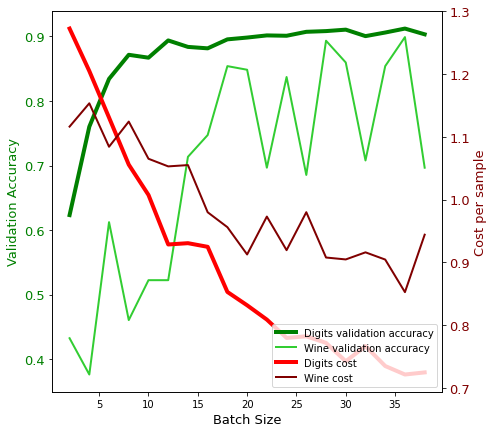

In [211]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,7)

    ax1.plot(batch_size_tests, np.asarray(batch_size_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(batch_size_tests, np.asarray(batch_size_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Batch Size',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(batch_size_tests, np.asarray(batch_size_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(batch_size_tests, np.asarray(batch_size_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower right')

    plt.show()



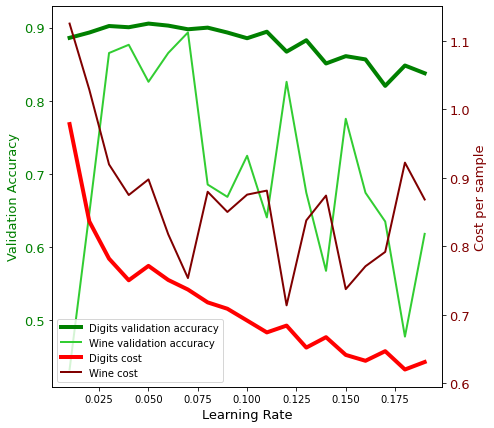

In [210]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,7)

    ax1.plot(learning_rate_tests, np.asarray(learning_rate_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(learning_rate_tests, np.asarray(learning_rate_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Learning Rate',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(learning_rate_tests, np.asarray(learning_rate_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(learning_rate_tests, np.asarray(learning_rate_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower left')

    plt.show()



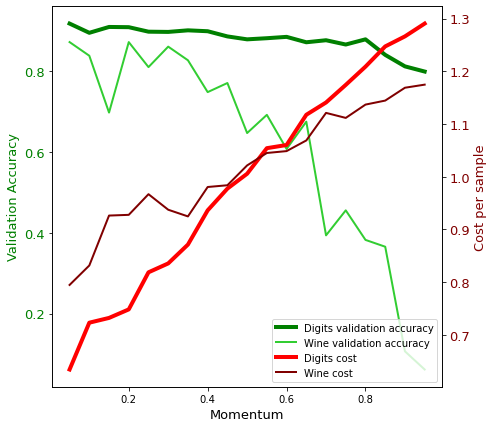

In [209]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,7)

    ax1.plot(momentum_tests, np.asarray(momentum_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(momentum_tests, np.asarray(momentum_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Momentum',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(momentum_tests, np.asarray(momentum_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(momentum_tests, np.asarray(momentum_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower right')

    plt.show()



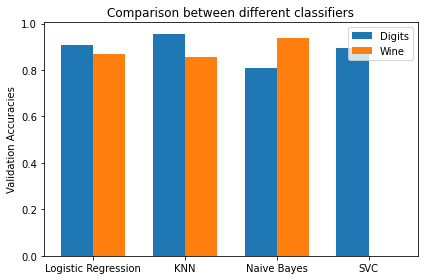

In [227]:
digits_validation_accuracies = [default_run[0],digits_knn_accuracy,digits_naive_accuracy,digits_svc_accuracy]
wine_validation_accuracies = [default_run[2],wine_knn_accuracy,wine_naive_accuracy,0]

labels = ["Logistic Regression","KNN","Naive Bayes","SVC"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, digits_validation_accuracies, width, label='Digits')
rects2 = ax.bar(x + width/2, wine_validation_accuracies, width, label='Wine')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation Accuracies')
ax.set_title('Comparison between different classifiers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()